***Import libraires and data, set up stuff***

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import anndata as ad


In [2]:
scv.set_figure_params()

In [3]:
sample = sc.read('../data/notebooks_data/sample_123.filt.norm.clst.h5ad')

Only considering the two last: ['.clst', '.h5ad'].
Only considering the two last: ['.clst', '.h5ad'].


In [4]:
cellsToKeep = [ i not in ['Leydig','Endothelial','Myoid'] for i in sample.obs['clusters'] ]
sample = sample[ cellsToKeep ].copy()

In [38]:
import bbknn.matrix
distances, connectivities, _ = bbknn.matrix.bbknn(sample.obsm['X_umap'], 
                                                           sample.obs['batch'],
                                                 neighbors_within_batch=10)

In [39]:
sample.obsp['connectivities'] = connectivities
sample.obsp['distances'] = distances

In [40]:
scv.pp.moments(sample, use_highly_variable=True, use_rep='X_pca')

computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [41]:
#sample=sample[:,sample.var['highly_variable']].copy()

In [42]:
scv.tl.velocity(sample, mode='stochastic', use_highly_variable=True)

computing velocities
    finished (0:00:29) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [43]:
scv.tl.velocity_graph(sample, n_jobs=4)

computing velocity graph (using 4/64 cores)


  0%|          | 0/10678 [00:00<?, ?cells/s]

    finished (0:00:47) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


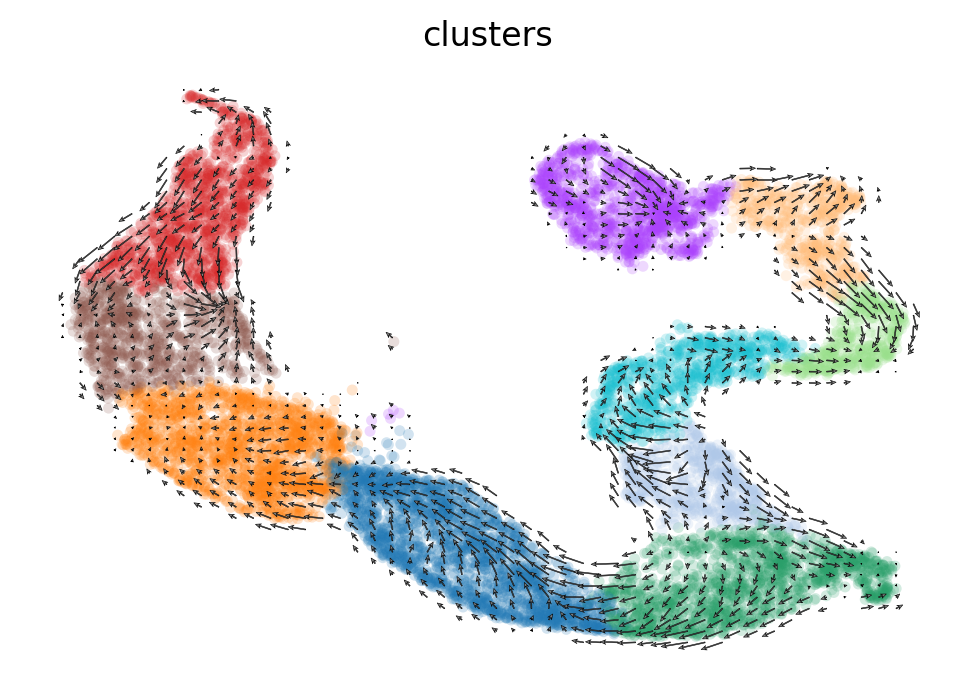

In [44]:
scv.pl.velocity_embedding_grid(sample, basis='umap', arrow_length=3)

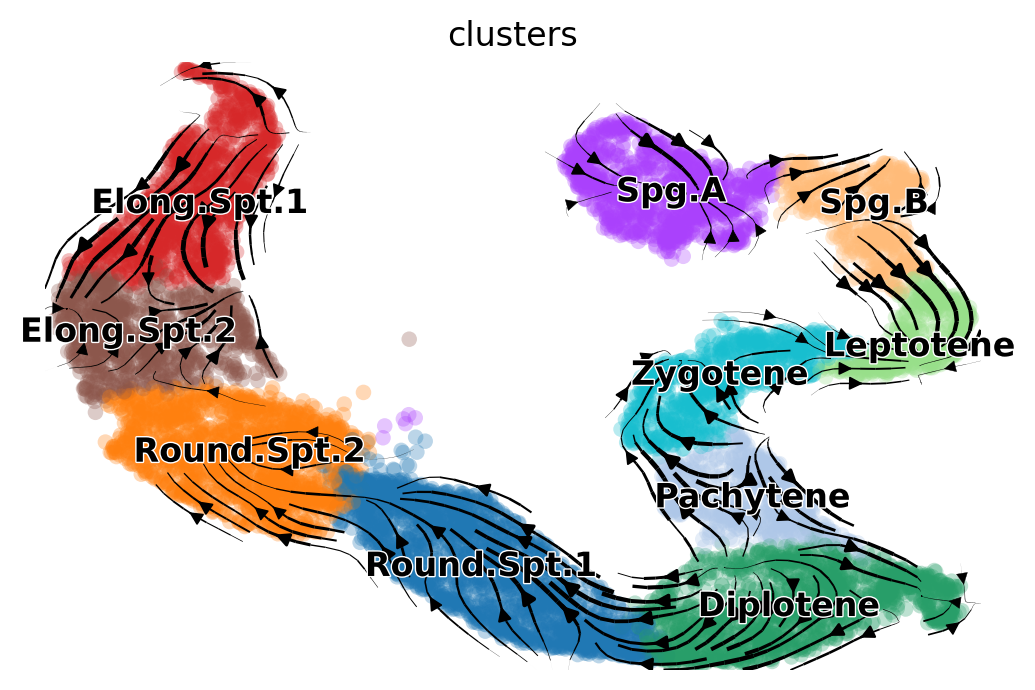

In [45]:
scv.pl.velocity_embedding_stream(sample, basis='umap')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


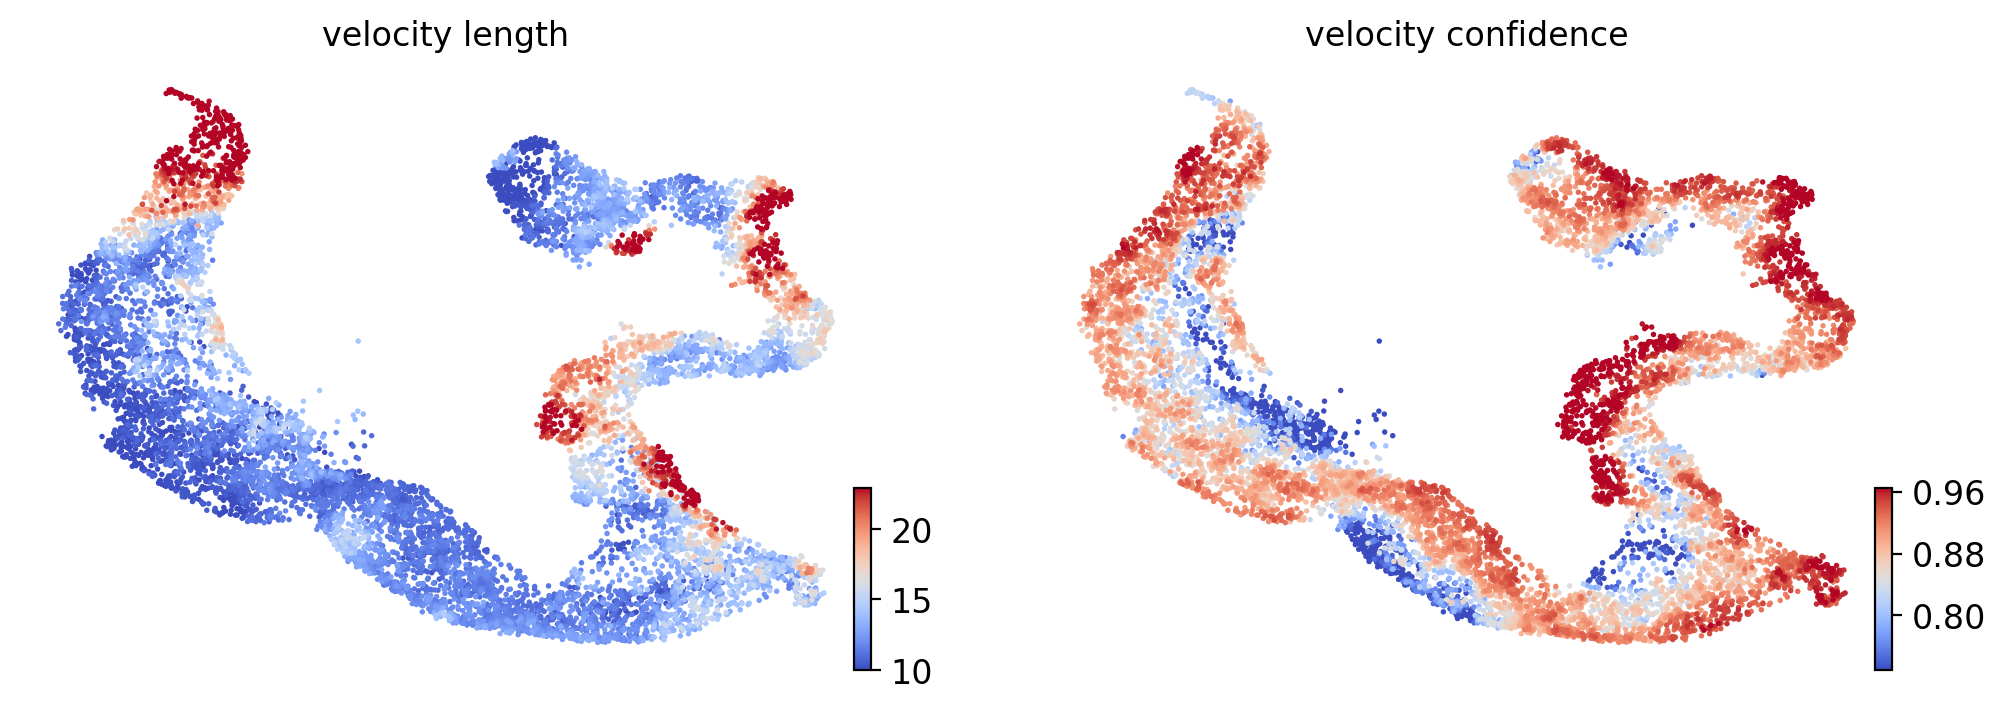

In [46]:
scv.tl.velocity_confidence(sample)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(sample, c=keys, cmap='coolwarm', perc=[5, 95])

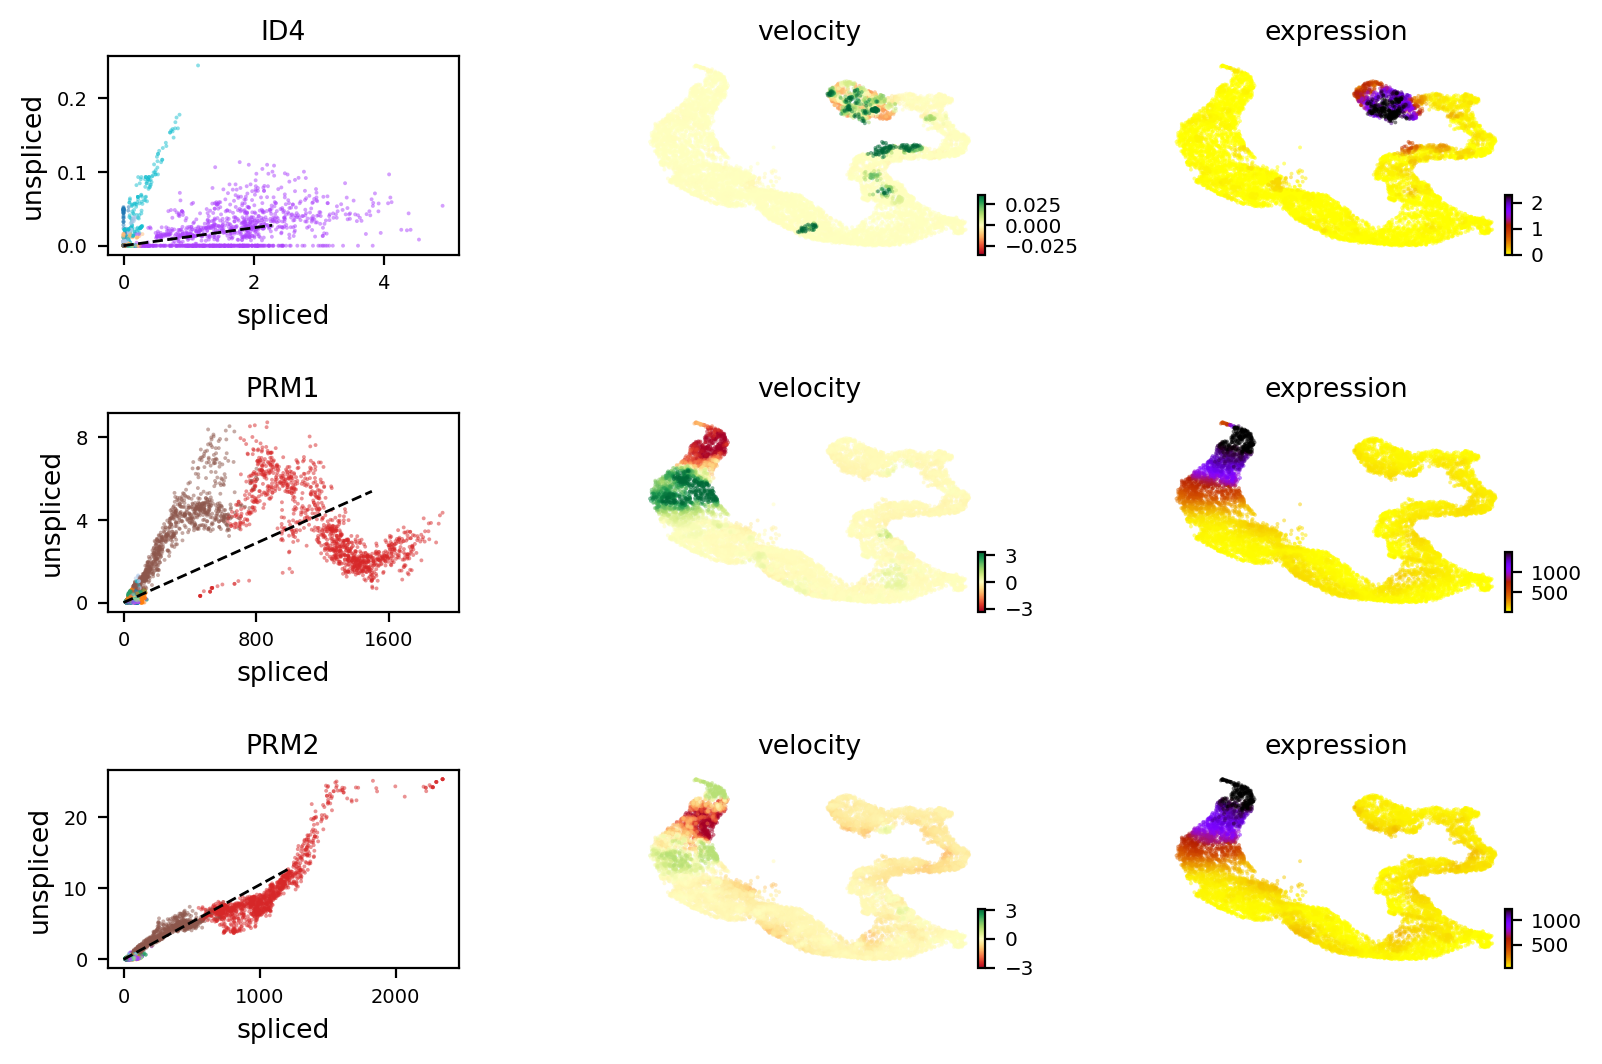

In [47]:
scv.pl.velocity(sample, var_names=['ID4', 'PRM1','PRM2'])

In [48]:
keys = 'velocity_length', 'velocity_confidence'
df = sample.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

clusters,Round.Spt.1,Round.Spt.2,Diplotene,Elong.Spt.1,Spg.A,Elong.Spt.2,Zygotene,Pachytene,Spg.B,Leptotene
velocity_length,11.631845,11.157979,13.191971,17.730627,12.243980,11.842812,17.393103,16.878744,18.313791,15.233915
velocity_confidence,0.862133,0.837466,0.885418,0.888723,0.892923,0.861014,0.934128,0.887425,0.940156,0.906728


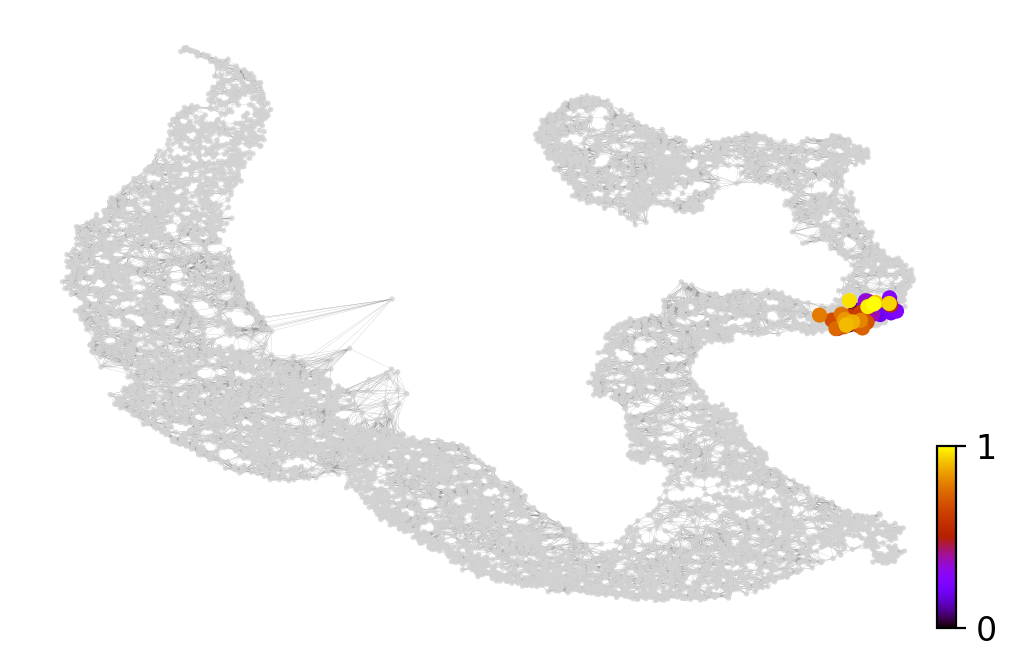

In [49]:
CLUSTER_OF_ORIGIN = 'Leptotene'
idx = np.where(sample.obs['clusters']==CLUSTER_OF_ORIGIN)[0]
x, y = scv.utils.get_cell_transitions(sample, basis='umap', starting_cell=idx[3])
ax = scv.pl.velocity_graph(sample, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(sample, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

In [55]:
sample.obs['clusters'].cat.categories

Index(['Round.Spt.1', 'Round.Spt.2', 'Diplotene', 'Elong.Spt.1', 'Spg.A',
       'Elong.Spt.2', 'Zygotene', 'Pachytene', 'Spg.B', 'Leptotene'],
      dtype='object')

In [56]:
# this is needed due to a current bug - bugfix is coming soon.
sample.uns['neighbors']['distances'] = sample.obsp['distances']
sample.uns['neighbors']['connectivities'] = sample.obsp['connectivities']

scv.tl.paga(sample, groups='clusters')
df = scv.get_df(sample, 'paga/transitions_confidence', precision=2).T
df.index =sample.obs['clusters'].cat.categories
df.columns = sample.obs['clusters'].cat.categories
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,Round.Spt.1,Round.Spt.2,Diplotene,Elong.Spt.1,Spg.A,Elong.Spt.2,Zygotene,Pachytene,Spg.B,Leptotene
Round.Spt.1,0,0,0,0,0,0,0,0,0,0
Round.Spt.2,0.053,0,0,0,0,0,0,0,0,0
Diplotene,0,0,0,0,0,0,0,0.31,0,0
Elong.Spt.1,0,0,0,0,0,0.096,0,0,0,0
Spg.A,0,0,0,0,0,0,0,0,0.043,0
Elong.Spt.2,0,0.14,0,0,0,0,0,0,0,0
Zygotene,0,0,0,0,0,0,0,0,0,0
Pachytene,0,0,0,0,0,0,0.11,0,0,0
Spg.B,0,0,0,0,0,0,0,0,0,0.12
Leptotene,0,0,0,0,0,0,0,0,0,0


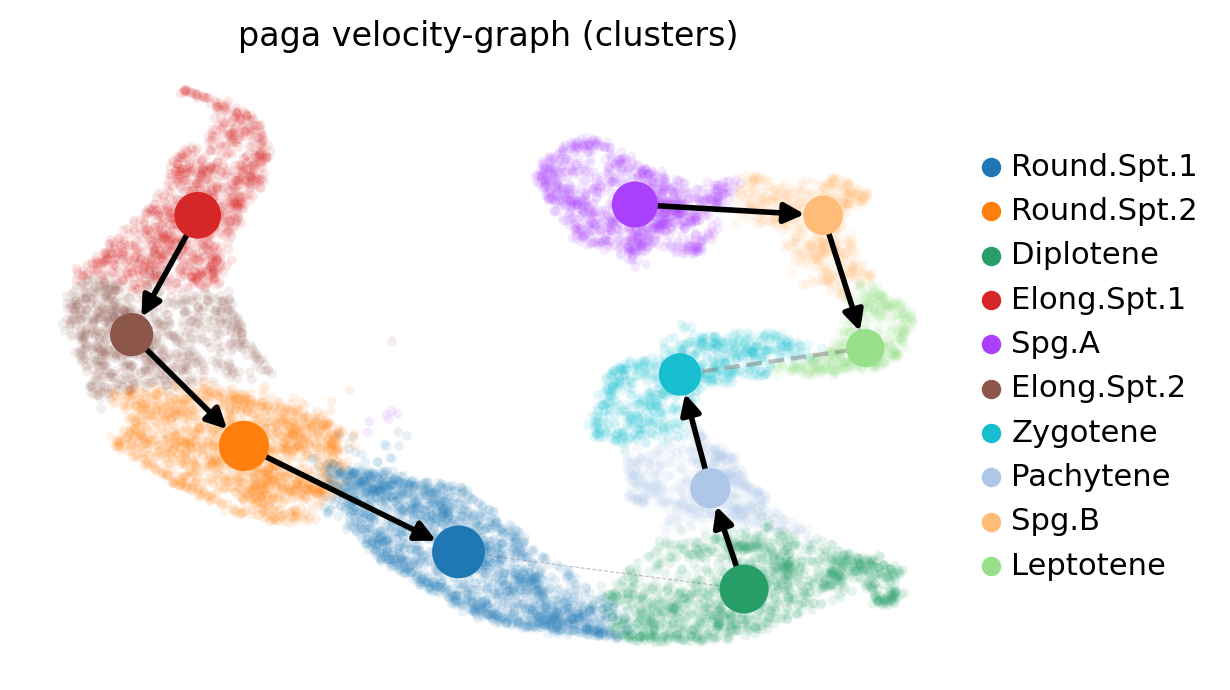

In [57]:
scv.pl.paga(sample, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)